In [1]:
import os
import matplotlib.pyplot as plt
import torch
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
SMOKE_TEST = os.environ.get("SMOKE_TEST")


If no GPU change "cuda" to "cpu"

In [2]:
tkwargs = {
    "device": torch.device("cuda"),
    "dtype": torch.double,
}

In [3]:
def smooth_mask(x, a, eps=2e-3):
    """Returns 0ish for x < a and 1ish for x > a"""
    return torch.nn.Sigmoid()((x - a) / eps)


def smooth_box_mask(x, a, b, eps=2e-3):
    """Returns 1ish for a < x < b and 0ish otherwise"""
    return smooth_mask(x, a, eps) - smooth_mask(x, b, eps)

class ExpectedCoverageImprovement(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        constraints,
        punchout_radius,
        bounds,
        num_samples=512,
        **kwargs,
    ):
        """Expected Coverage Improvement (q=1 required, analytic)

        Right now, we assume that all the models in the ModelListGP have
        the same training inputs.

        Args:
            model: A ModelListGP object containing models matching the corresponding constraints.
                All models are assumed to have the same training data.
            constraints: List containing 2-tuples with (direction, value), e.g.,
                [('gt', 3), ('lt', 4)]. It is necessary that
                len(constraints) == model.num_outputs.
            punchout_radius: Positive value defining the desired minimum distance between points
            bounds: torch.tensor whose first row is the lower bounds and second row is the upper bounds
            num_samples: Number of samples for MC integration
        """
        super().__init__(model=model, objective=IdentityMCObjective(), **kwargs)
        assert len(constraints) == model.num_outputs
        assert all(direction in ("gt", "lt") for direction, _ in constraints)
        assert punchout_radius > 0
        self.constraints = constraints
        self.punchout_radius = punchout_radius
        self.bounds = bounds
        self.base_points = self.train_inputs
        self.ball_of_points = self._generate_ball_of_points(
            num_samples=num_samples,
            radius=punchout_radius,
            device=bounds.device,
            dtype=bounds.dtype,
        )
        self._thresholds = torch.tensor(
            [threshold for _, threshold in self.constraints]
        ).to(bounds)
        assert (
            all(ub > lb for lb, ub in self.bounds.T) and len(self.bounds.T) == self.dim
        )

    @property
    def num_outputs(self):
        return self.model.num_outputs

    @property
    def dim(self):
        return self.train_inputs.shape[-1]

    @property
    def train_inputs(self):
        return self.model.models[0].train_inputs[0]

    def _generate_ball_of_points(
        self, num_samples, radius, device=None, dtype=torch.double
    ):
        """Creates a ball of points to be used for MC."""
        tkwargs = {"device": device, "dtype": dtype}
        z = sample_hypersphere(d=self.dim, n=num_samples, qmc=True, **tkwargs)
        r = torch.rand(num_samples, 1, **tkwargs) ** (1 / self.dim)
        return radius * r * z

    def _get_base_point_mask(self, X):
        distance_matrix = self.model.models[0].covar_module.base_kernel.covar_dist(
            X, self.base_points
        )
        return smooth_mask(distance_matrix, self.punchout_radius)

    def _estimate_probabilities_of_satisfaction_at_points(self, points):
        """Estimate the probability of satisfying the given constraints."""
        posterior = self.model.posterior(X=points)
        mus, sigma2s = posterior.mean, posterior.variance
        dist = torch.distributions.normal.Normal(mus, sigma2s.sqrt())
        norm_cdf = dist.cdf(self._thresholds)
        probs = torch.ones(points.shape[:-1]).to(points)
        for i, (direction, _) in enumerate(self.constraints):
            probs = probs * (
                norm_cdf[..., i] if direction == "lt" else 1 - norm_cdf[..., i]
            )
        return probs

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X):
        """Evaluate Expected Improvement on the candidate set X."""
        ball_around_X = self.ball_of_points + X
        domain_mask = smooth_mask(
            ball_around_X, self.bounds[0, :], self.bounds[1, :]
        ).prod(dim=-1)
        num_points_in_integral = domain_mask.sum(dim=-1)
        base_point_mask = self._get_base_point_mask(ball_around_X).prod(dim=-1)
        prob = self._estimate_probabilities_of_satisfaction_at_points(ball_around_X)
        masked_prob = prob * domain_mask * base_point_mask
        y = masked_prob.sum(dim=-1) / num_points_in_integral
        return y

In [4]:
def get_and_fit_gp(X, Y):
    """Simple method for creating a GP with one output dimension.

    X is assumed to be in [0, 1]^d.
    """
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-6, 1e-3))  # Noise-free
    octf = Standardize(m=Y.shape[-1])
    gp = SingleTaskGP(X, Y, likelihood=likelihood, outcome_transform=octf)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

In [5]:
def hills(x):
    v = 0.5*torch.cos(x[:,0]*2-torch.pi)+torch.sin(x[:,1]+torch.pi/2)
    
    return torch.stack((v, v), dim=-1)

In [6]:
def circle(x):
    v = -(x[:,0] ** 2 + x[:,1] ** 2) + 25
    return torch.stack((v, v), dim=-1)

In [7]:
bounds = torch.tensor([[-3, -3], [3, 3]], **tkwargs)
lb, ub = bounds
dim = len(lb)
punchout_radius = 0.6

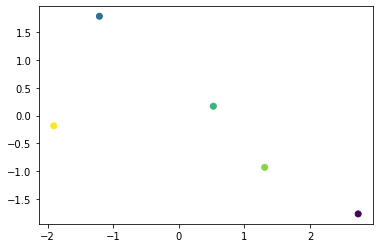

In [8]:
import copy
num_init_points = 5
num_total_points = 20 
Xhills = lb + (ub - lb) * SobolEngine(dim, scramble=True).draw(num_init_points).to(**tkwargs)
Yhills = hills(Xhills)
Xcircle = copy.deepcopy(Xhills)
Ycircle = circle(Xcircle)
plt.scatter(Xhills.cpu().numpy()[:, 0], Xhills.cpu().numpy()[:, 1], c=Yhills.cpu()[:,0])

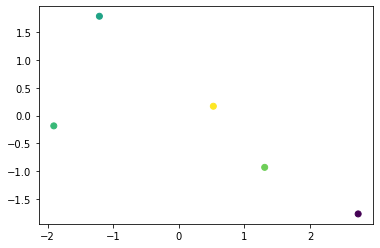

In [9]:
plt.scatter(Xcircle.cpu().numpy()[:, 0], Xcircle.cpu().numpy()[:, 1], c=Ycircle.cpu()[:,0])

In [10]:
constraints = [("lt", 2), ("gt", 0.3), ("lt", 30), ("gt", 20)]

# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std
i = 1
while len(Xhills) < num_total_points:
    # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
    # appropriately adjust the punchout radius if the domain is normalized.
    gp_model_hills = [get_and_fit_gp(Xhills, Yhills[:, i : i + 1]) for i in range(Yhills.shape[-1])]
    gp_model_circle = [get_and_fit_gp(Xcircle, Ycircle[:, i : i + 1]) for i in range(Ycircle.shape[-1])]
    model_list_gp = ModelListGP(gp_model_hills[0], gp_model_hills[1], gp_model_circle[0], gp_model_circle[1])

    eci = ExpectedCoverageImprovement(
        model=model_list_gp,
        constraints=constraints,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=512 if not SMOKE_TEST else 4,
    )

    x_next, _ = optimize_acqf(
        acq_function=eci,
        bounds=bounds,
        q=1,
        num_restarts=10 if not SMOKE_TEST else 2,
        raw_samples=512 if not SMOKE_TEST else 4,
    )

    print(f"New X No. {i}")
    i += 1
    y_next_hills = hills(x_next)
    y_next_circle = circle(x_next)

    Xhills = torch.cat((Xhills, x_next))
    Xcircle = torch.cat((Xcircle, x_next))
    Yhills = torch.cat((Yhills, y_next_hills))
    Ycircle = torch.cat((Ycircle, y_next_circle))

c:\Program Files\Python310\lib\site-packages\botorch\fit.py:148: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\Leo\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  ..\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  warnings.warn(w.message, w.category)


New X No. 1
New X No. 2
New X No. 3
New X No. 4
New X No. 5
New X No. 6
New X No. 7
New X No. 8
New X No. 9
New X No. 10
New X No. 11
New X No. 12
New X No. 13
New X No. 14
New X No. 15


In [11]:
def identify_samples_which_satisfy_constraints(X, constraints):
    """
    Takes in values (a1, ..., ak, o) and returns (a1, ..., ak, o)
    True/False values, where o is the number of outputs.
    """
    successful = torch.ones(X.shape).to(X)
    for model_index in range(X.shape[-1]):
        these_X = X[..., model_index]
        direction, value = constraints[model_index]
        successful[..., model_index] = (
            these_X < value if direction == "lt" else these_X > value
        )
    return successful

In [12]:
N1, N2 = 75, 75
Xplt_hills, Yplt_hills = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt_hills = torch.stack(
    (
        torch.reshape(Xplt_hills, (Xplt_hills.shape[0] * Xplt_hills.shape[1],)),
        torch.reshape(Yplt_hills, (Yplt_hills.shape[0] * Yplt_hills.shape[1],)),
    ),
    dim=1,
)
yplt_hills = hills(xplt_hills)
Zplt_hills = torch.reshape(yplt_hills[:, 0], (N1, N2)) 

feasible_inds_hills = (
    identify_samples_which_satisfy_constraints(Yhills, constraints[:2])
    .prod(dim=-1)
    .to(torch.bool)
)

c:\Program Files\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
Xplt_circle, Yplt_circle = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt_circle = torch.stack(
    (
        torch.reshape(Xplt_circle, (Xplt_circle.shape[0] * Xplt_circle.shape[1],)),
        torch.reshape(Yplt_circle, (Yplt_circle.shape[0] * Yplt_circle.shape[1],)),
    ),
    dim=1,
)
yplt_circle = circle(xplt_circle)
Zplt_circle = torch.reshape(yplt_circle[:, 0], (N1, N2)) 

feasible_inds_circle = (
    identify_samples_which_satisfy_constraints(Ycircle, constraints[2:])
    .prod(dim=-1)
    .to(torch.bool)
)


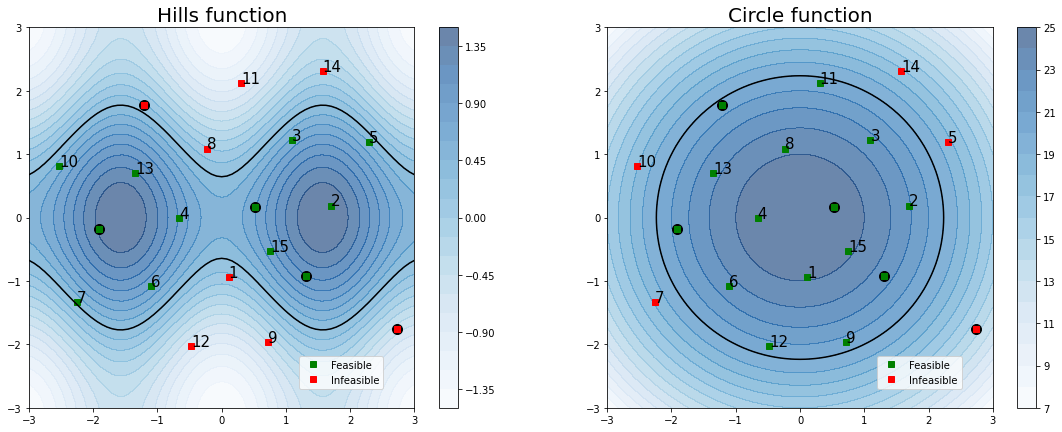

In [14]:
fig, ax = plt.subplots(1,2, figsize=(19, 7))
plot1 = ax[0].contourf(Xplt_hills.cpu(), Yplt_hills.cpu(), Zplt_hills.cpu(), 20, cmap="Blues", alpha=0.6)
ax[0].plot(Xhills[feasible_inds_hills, 0].cpu(), Xhills[feasible_inds_hills, 1].cpu(), "sg", label="Feasible")
ax[0].plot(
    Xhills[~feasible_inds_hills, 0].cpu(), Xhills[~feasible_inds_hills, 1].cpu(), "sr", label="Infeasible"
)
ax[0].scatter(Xhills.cpu()[:5, 0], Xhills.cpu()[:5, 1], marker = 'o', s=100, color = 'k')
ind = 1

for i in Xhills[5:]:
    ax[0].text(i[0],i[1],ind, size = 15)
    ind += 1
ax[0].legend(loc=[0.7, 0.05])
ax[0].set_title('Hills function', fontsize=20)

ax[0].contour(Xplt_hills.cpu(), Yplt_hills.cpu(), Zplt_hills.cpu(), [constraints[1][1], constraints[0][1]], colors="k")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].contourf(Xplt_circle.cpu(), Yplt_circle.cpu(), Zplt_circle.cpu(), 20, cmap="Blues", alpha=0.6)
ax[1].plot(Xcircle[feasible_inds_circle, 0].cpu(), Xcircle[feasible_inds_circle, 1].cpu(), "sg", label="Feasible")
ax[1].plot(
    Xcircle[~feasible_inds_circle, 0].cpu(), Xcircle[~feasible_inds_circle, 1].cpu(), "sr", label="Infeasible"
)
ax[1].scatter(Xcircle.cpu()[:5, 0], Xcircle.cpu()[:5, 1], marker = 'o', s=100, color = 'k')
ax[1].contour(Xplt_circle.cpu(), Yplt_circle.cpu(), Zplt_circle.cpu(), [constraints[3][1], constraints[2][1]], colors="k")
ind = 1
for i in Xcircle[5:]:
    ax[1].text(i[0],i[1],ind, size = 15)
    ind += 1
ax[1].legend(loc=[0.7, 0.05])
ax[1].set_title('Circle function', fontsize=20)
fig.colorbar(plot2, location='right')


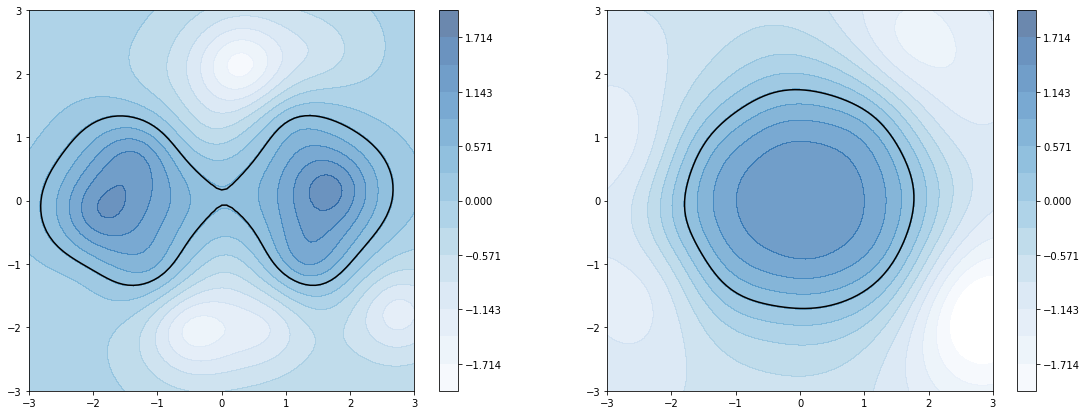

In [15]:
N1, N2 = 75, 75
Xplt, Yplt = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
yplt_hills = gp_model_hills[0](xplt).loc
yplt_circle = gp_model_circle[0](xplt).loc

Zplt_hills = torch.reshape(yplt_hills, (N1, N2))
Zplt_circle = torch.reshape(yplt_circle, (N1, N2)) 
fig, ax = plt.subplots(1,2, figsize=(19, 7))
h1 = ax[0].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), Zplt_hills.cpu().detach(), levels=np.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[0].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), Zplt_hills.cpu().detach(), [0.3, 2], colors="k")
fig.colorbar(h1, ax=ax[0])

h2 = ax[1].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), Zplt_circle.cpu().detach(), levels=np.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[1].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), Zplt_circle.cpu().detach(), [0.3, 2], colors="k")
fig.colorbar(h2, ax=ax[1])


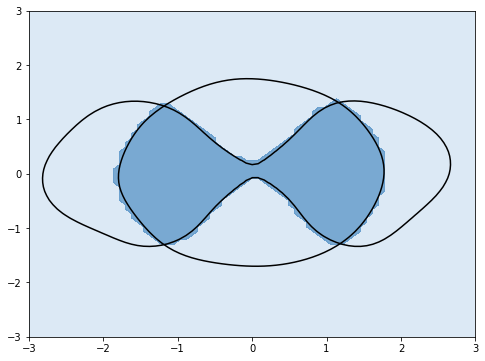

In [16]:
satisfied_hills = Zplt_hills > 0.3
satisfied_circle = Zplt_circle > 0.3
overlap = satisfied_hills & satisfied_circle
constraints_list = [constraints[1][1], constraints[0][1]]

plt.subplots(figsize=(8, 6))
plt.contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), overlap.cpu().detach(), levels=np.linspace(-1, 1, 3), cmap="Blues", alpha=0.6)
plt.contour(Xplt_hills.cpu().detach(), Yplt_hills.cpu().detach(), Zplt_hills.cpu().detach(), constraints_list, colors="k")
plt.contour(Xplt_circle.cpu().detach(), Yplt_circle.cpu().detach(), Zplt_circle.cpu().detach(), constraints_list, colors="k")


Comment it out if no GPU

In [17]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()